# Options IV Calculation Test

This notebook tests the options data fetching and implied volatility (IV) calculation pipeline.


In [134]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
from adapters.options_adapter import OptionsAdapter
from adapters.rates_adapter import RatesAdapter
from adapters.ticker_adapter import TickerAdapter
from models.options_data import OptionsRequest, OptionType
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
from engines.IV_smile import IVEngine


In [136]:
from update_rates import updateRates
updateRates()

FRED_API_KEY present: yes
Starting updateRates...
Starting rate updates...
No new discount factor data available from 2025-12-19
No new SOFR data available from 2025-12-19
Rate updates completed.
updateRates completed.
Last discount_factors date: 2025-12-18
SOFR update was included.


## Setup

Initialize the adapter and create the options request.


In [231]:
adapter = OptionsAdapter()

# Simulate duration selection (e.g. '1y' from frontend)
today = date.today()
expiry_start = today + relativedelta(weeks=4)
expiry_end = today + relativedelta(weeks=56)

req = OptionsRequest(
    ticker="NVDA",
    optionType=OptionType.CALL,
    expiryStart=expiry_start,
    expiryEnd=expiry_end,
    moneynessMin=0.8,
    moneynessMax=1.2,
)


## Fetch Options Data


In [232]:
print(f"Requesting options for {req.ticker} until {expiry_end}...")
df = adapter.fetch_option_chain(req)
print(f"Fetched {len(df)} contracts.")



Requesting options for NVDA until 2027-01-16...
Fetched 237 contracts.


## Display Options Data


In [233]:
df[["optionType", "strike", "timeToExpiry", "midPrice", "expiry"]]

,optionType,strike,timeToExpiry,midPrice,expiry
0,call,150.0,0.093132,31.930,2026-01-23
1,call,155.0,0.093132,27.545,2026-01-23
2,call,160.0,0.093132,23.080,2026-01-23
3,call,165.0,0.093132,18.895,2026-01-23
4,call,170.0,0.093132,14.900,2026-01-23
...,...,...,...,...,...
232,call,190.0,1.071214,32.760,2027-01-15
233,call,195.0,1.071214,30.210,2027-01-15
234,call,200.0,1.071214,29.075,2027-01-15
235,call,210.0,1.071214,25.150,2027-01-15


## Calculate Implied Volatility


In [234]:
from engines.zero_rates import ZeroRatesEngine

df["rate"] = ZeroRatesEngine.interpolate_zero_rate(df, tte_col="timeToExpiry")

base_info = TickerAdapter.fetchBasic(req.ticker)
div = base_info.dividendYield
spot = base_info.spot
#
#print(f"Spot price: ${spot:.2f}")
#print(f"Risk-free rate: {rate:.4f}")
#print(f"Dividend yield: {div:.4f}%")
#print("\nCalculating IVs...")
#
surface_data = IVEngine.generateIVSmile(df, df["rate"], div/100, spot, OptionType.CALL) #type: ignore
surface_data.dropna(inplace=True)




In [235]:
print("\nIV Calculation Results:")
surface_data[["expiry", "iv"]]



IV Calculation Results:


,expiry,iv
0,2026-01-23,0.386630
1,2026-01-23,0.410578
2,2026-01-23,0.394963
3,2026-01-23,0.383524
4,2026-01-23,0.365331
...,...,...
232,2027-01-15,0.454158
233,2027-01-15,0.444863
234,2027-01-15,0.453380
235,2027-01-15,0.444284


In [236]:
import numpy as np
surface_data["F"] = spot * np.exp((surface_data["rate"] - div/100) * surface_data["T"])
surface_data["k"] = np.log(surface_data["K"] / surface_data["F"])
surface_data["w"] = surface_data["iv"] ** 2 * surface_data["T"]
surface_data[["K", "w", "k", "expiry" ,"F"]]
#print(f"Spot: {spot}")

,K,w,k,expiry,F
0,150.0,0.013922,-0.191223,2026-01-23,181.609409
1,155.0,0.015700,-0.158433,2026-01-23,181.609409
2,160.0,0.014528,-0.126684,2026-01-23,181.609409
3,165.0,0.013699,-0.095913,2026-01-23,181.609409
4,170.0,0.012430,-0.066060,2026-01-23,181.609409
...,...,...,...,...,...
232,190.0,0.220948,0.011784,2027-01-15,187.774179
233,195.0,0.211997,0.037759,2027-01-15,187.774179
234,200.0,0.220192,0.063077,2027-01-15,187.774179
235,210.0,0.211445,0.111867,2027-01-15,187.774179


In [237]:
theta_low = surface_data[surface_data["k"] <0].groupby("T")[["expiry","k","w","K","F","iv"]].max()
theta_high = surface_data[surface_data["k"] >0].groupby("T")[["expiry","k","w","K","F","iv"]].min()
interpolated_values = theta_high["w"] - (theta_high["w"] - theta_low["w"]) * (theta_high["k"] / (theta_high["k"] - theta_low["k"]))
#print(theta_high.iloc[-1])
#print(theta_low.iloc[-5:])
surface_data["theta"] = surface_data["T"].map(interpolated_values)
surface_data[["expiry", "k", "w", "theta"]]




,expiry,k,w,theta
0,2026-01-23,-0.191223,0.013922,0.013738
1,2026-01-23,-0.158433,0.015700,0.013738
2,2026-01-23,-0.126684,0.014528,0.013738
3,2026-01-23,-0.095913,0.013699,0.013738
4,2026-01-23,-0.066060,0.012430,0.013738
...,...,...,...,...
232,2027-01-15,0.011784,0.220948,0.224323
233,2027-01-15,0.037759,0.211997,0.224323
234,2027-01-15,0.063077,0.220192,0.224323
235,2027-01-15,0.111867,0.211445,0.224323


In [253]:
vega = IVEngine._vega(surface_data["iv"], surface_data["K"], surface_data["T"], surface_data["rate"], div, surface_data["F"])
surface_data["vega"] = np.clip(vega, 1e-6, None)
print(f"Spot price: ${spot:.2f}")
surface_data[["expiry", "K", "k", "vega"]]

Spot price: $180.99


,expiry,K,k,vega
0,2026-01-23,150.0,-0.191223,5.264982
1,2026-01-23,155.0,-0.158433,8.996733
2,2026-01-23,160.0,-0.126684,11.729525
3,2026-01-23,165.0,-0.095913,14.833185
4,2026-01-23,170.0,-0.066060,17.722311
...,...,...,...,...
232,2027-01-15,190.0,0.011784,73.679183
233,2027-01-15,195.0,0.037759,74.641774
234,2027-01-15,200.0,0.063077,75.216695
235,2027-01-15,210.0,0.111867,75.873145


In [254]:
T_vals = surface_data["T"].values
T_unique = np.sort(surface_data["T"].unique())
T_to_index = {t: i for i, t in enumerate(T_unique)}
idx = np.array([T_to_index[t] for t in T_vals]) # index for each row to use on T_unique to find eta
x0 = np.r_[ -0.3, np.full(len(T_unique), 0.5) ]    # rho, eta_i-1



In [255]:
def ssvi_w(k, theta, phi, rho):
    w_ssvi = (
        1
        / 2
        * theta
        * (1 + rho * phi * k + np.sqrt((phi * k + rho) ** 2 + 1 - rho**2))
    )
    return w_ssvi


In [256]:
vegas = surface_data["vega"].values
weights = vegas / np.sum(vegas)

In [257]:
def objective(x, theta, k, w_mkt, idx):
    rho_raw = x[0]
    rho = np.tanh(rho_raw) 
    eta = x[1:]
    phi = eta[idx] / np.sqrt(np.maximum(theta, 1e-12))
    w_model = ssvi_w(k, theta, phi, rho)
    error = (w_model - w_mkt)
    loss = np.dot(error, error) 
    return loss

In [ ]:
#def butterfly_constraint(x):
#    eta, rho = x
#    return 2 - eta * (1 + abs(rho))

def make_constraints(n_expiries):
    cons = []
    for i in range(n_expiries):
        cons.append({
            "type": "ineq",
            "fun": lambda x, i=i: 2 - x[1+i] * (1 + abs(x[0]))
        })
    return cons


In [265]:
from scipy.optimize import minimize

bounds = [(-5.0, 5.0)] + [(1e-5, 2)] * len(T_unique)
w_mkt = surface_data["w"].values
k = surface_data["k"].values
theta = surface_data["theta"].values


res = minimize(
    objective,
    x0=x0,
    args=(theta, k, w_mkt, idx),
    method="SLSQP",
    bounds=bounds,
    constraints=make_constraints(len(T_unique))
)

#print(res.x)
print(f"Optimised Rho: {np.tanh(res.x[0]):.6f}")
print(f"Optimised Eta: {res.x[1:]}")

surface_data["w_ssvi"] = ssvi_w(k, theta, phi= res.x[1:][idx] / np.sqrt(np.maximum(theta, 1e-12)), rho=np.tanh(res.x[0])) #type: ignore
error = objective(res.x, theta, k, w_mkt, idx)
print(f"SSVI Loss: {error:.6f}")


err = np.abs(surface_data["w_ssvi"].values) - np.abs(surface_data["w"].values) # type: ignore
relative = err / np.maximum(np.abs(surface_data["w"].values), 1e-6) # type: ignore
print(f"Mean Relative Error: {np.mean(relative)*100:.4f}%")


Optimised Rho: -0.946653
Optimised Eta: [0.07564859 0.13733852 0.15434626 0.18112496 0.21546978 0.20263017
 0.10381038 0.27201636 0.09622568 0.08660794 0.16006233 0.19910083]
SSVI Loss: 0.043650
Mean Relative Error: 11.8378%


In [260]:
surface_data["residuals"] = surface_data["w_ssvi"] - surface_data["w"]
surface_data["relative_residuals"] = (surface_data["residuals"] / surface_data["w"])*100
surface_data[["expiry", "K", "iv", "w", "w_ssvi", "relative_residuals"]]

,expiry,K,iv,w,w_ssvi,relative_residuals
0,2026-01-23,150.0,0.386630,0.013922,0.018681,34.185456
1,2026-01-23,155.0,0.410578,0.015700,0.017833,13.589888
2,2026-01-23,160.0,0.394963,0.014528,0.017012,17.099970
3,2026-01-23,165.0,0.383524,0.013699,0.016217,18.382334
4,2026-01-23,170.0,0.365331,0.012430,0.015445,24.258055
...,...,...,...,...,...,...
232,2027-01-15,190.0,0.454158,0.220948,0.222964,0.912105
233,2027-01-15,195.0,0.444863,0.211997,0.219966,3.759020
234,2027-01-15,200.0,0.453380,0.220192,0.217045,-1.429372
235,2027-01-15,210.0,0.444284,0.211445,0.211414,-0.014660


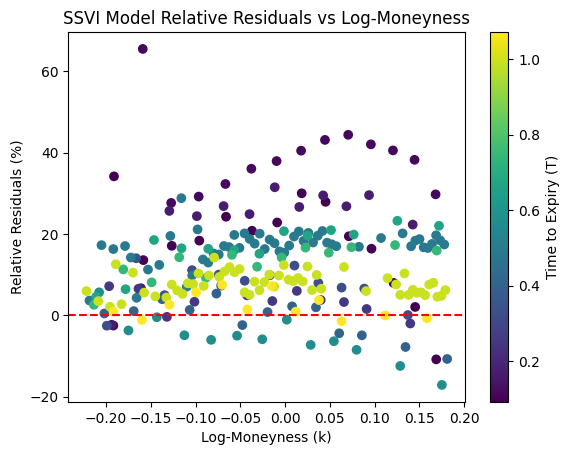

In [270]:
import matplotlib.pyplot as plt
plt.scatter(surface_data["k"], surface_data["relative_residuals"], c=surface_data["T"], cmap="viridis")
plt.colorbar(label="Time to Expiry (T)")
plt.xlabel("Log-Moneyness (k)")
plt.ylabel("Relative Residuals (%)")
plt.title("SSVI Model Relative Residuals vs Log-Moneyness")
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [262]:
mean_residuals = surface_data.groupby("expiry")["residuals"].mean()
mean_residuals = mean_residuals.rename("mean_residuals") 
#print(mean_residuals)
mean_relative_residuals = surface_data.groupby("expiry")["relative_residuals"].mean()
mean_relative_residuals = mean_relative_residuals.rename("mean_relative_residuals")
#print(mean_relative_residuals)

In [267]:
surface_data["iv_ssvi"] = np.sqrt(surface_data["w_ssvi"] / surface_data["T"])
surface_data["iv_error"] = (surface_data["iv_ssvi"] / surface_data["iv"] - 1)*100
surface_data[["expiry", "K", "iv", "iv_ssvi", "iv_error"]]

,expiry,K,iv,iv_ssvi,iv_error
0,2026-01-23,150.0,0.386630,0.405948,4.996419
1,2026-01-23,155.0,0.410578,0.402272,-2.022913
2,2026-01-23,160.0,0.394963,0.398684,0.942121
3,2026-01-23,165.0,0.383524,0.395178,3.038551
4,2026-01-23,170.0,0.365331,0.391749,7.231365
...,...,...,...,...,...
232,2027-01-15,190.0,0.454158,0.456540,0.524377
233,2027-01-15,195.0,0.444863,0.454164,2.090667
234,2027-01-15,200.0,0.453380,0.451838,-0.340116
235,2027-01-15,210.0,0.444284,0.447326,0.684599


C:\Users\gryph\AppData\Local\Temp\ipykernel_11936\4148399127.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


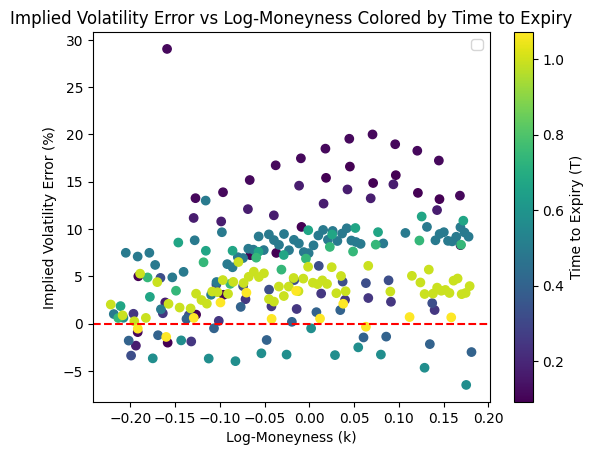

In [272]:
plt.scatter(surface_data["k"], surface_data["iv_error"], c=surface_data["T"], cmap="viridis")
plt.colorbar(label="Time to Expiry (T)")
plt.xlabel("Log-Moneyness (k)")
plt.ylabel("Implied Volatility Error (%)")
plt.title("Implied Volatility Error vs Log-Moneyness Colored by Time to Expiry")
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()